# Criando Base de Dados da Camila (Peixe Babel)

## 1. Baixar vídeo do YouTube

In [19]:
import youtube_dl

def download_youtube_video(youtube_url, video_filename):
    youtube_url = youtube_url.strip() 
    ydl_opts = {'outtmpl': video_filename}

    with youtube_dl.YoutubeDL(ydl_opts) as ydl:
        ydl.download([youtube_url])

In [20]:
import os.path

youtube_url = "https://www.youtube.com/watch?v=plq6tFA6mMY"
video_filename = "camila.mp4"

if os.path.isfile(video_filename) == False:
    download_youtube_video(youtube_url, video_filename)

## 2. Criar Pasta Contendo Faces para Treino

### 2.1 Treinar Face da Camila (Peixe Babel)

In [21]:
import os

folder_name = "Camila"
if os.path.isdir(folder_name) == False:
    os.mkdir(folder_name)

In [22]:
import dlib

shape_predictor_filename = "shape_predictor_68_face_landmarks.dat"

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(shape_predictor_filename)

In [5]:
import cv2
from matplotlib import pyplot as plt

def generateFolderWithFaces(folderName, videoFilename, thresholdFaces = 6, stepFrame = 10):
    detectedFacesCounter = 0
    faces = []
    frameCounter = 0

    #carrega vídeo
    videoCapture = cv2.VideoCapture(videoFilename)
    while 1:
        #contabiliza frames
        frameCounter += 1
        
        #pega o próximo frame
        success, frame = videoCapture.read()
        
        #acabou o vídeo ou detectou o limite de faces?
        if success == False or detectedFacesCounter >= thresholdFaces:
            return faces

        #"pula" alguns frames
        if frameCounter % stepFrame != 0:
            continue

        # detecta a face, o 1 indica superamostragem, pra achar faces mais facilmente
        detections = detector(frame, 1)
        for i, detection in enumerate(detections):
            
            #salvar região das faces em uma pasta
            x, y = detection.left(), detection.top()
            w, h = detection.right() - detection.left(), detection.bottom() - detection.top()
            faceCrop = frame[y:y + h, x:x + w]
            img_path = folderName + "/" + str(frameCounter) + ".jpg"
            cv2.imwrite(img_path, faceCrop)

            #essa parte é só pra adicionar retângulo ao redor da face e marcações, pra exibir bonitinho depois
            cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 255, 0), 4)
            landmarks = predictor(frame, detection)
            for i in range(0, 68): 
                cv2.circle(frame, (landmarks.part(i).x , landmarks.part(i).y), 4, (0, 0, 255), -1)      
            faces.append(frame)
        
        #total de faces detectadas até o momento
        detectedFacesCounter += len(detections)
        
    videoCapture.release()

In [6]:
exampleFaces = generateFolderWithFaces("Camila/", "camila.mp4")

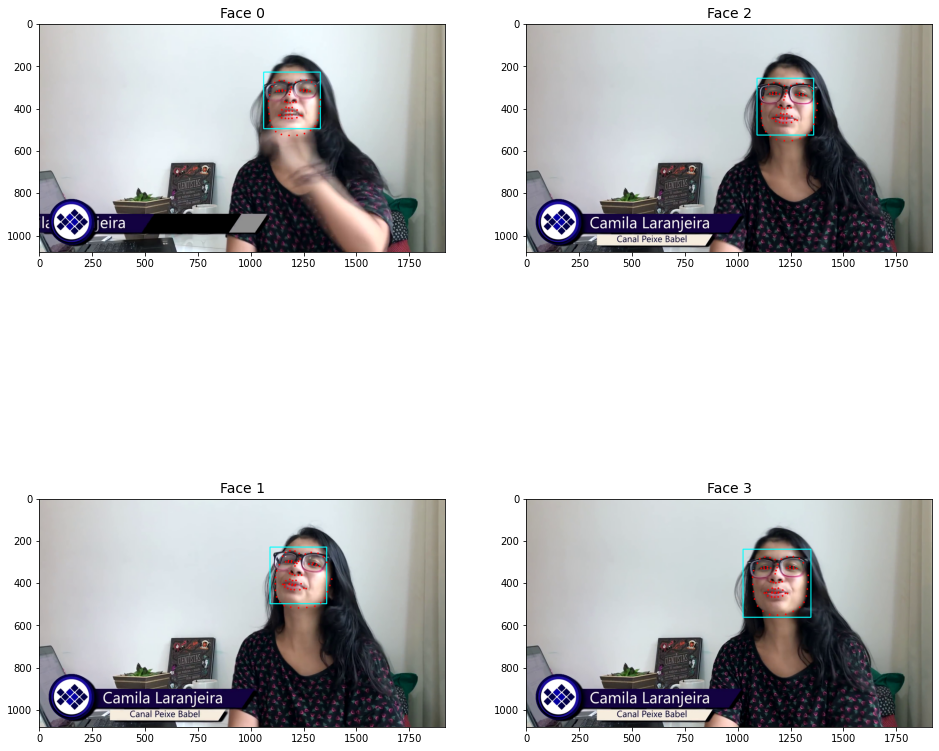

In [7]:
#mostra algumas faces detectadas de exemplo
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize=(16, 16))
i = 0
for y in range(0, 2):
    for x in range(0, 2):
        axes[x, y].set_title('Face ' + str(i), fontsize = 14)
        exampleFaces[i] = cv2.cvtColor(exampleFaces[i], cv2.COLOR_BGR2RGB)
        axes[x, y].imshow(exampleFaces[i])
        i += 1

# 2.2 Treinar uma Segunda Pessoa (Vivi)

In [8]:
folder_name = "Vivi"
if os.path.isdir(folder_name) == False:
    os.mkdir(folder_name)

In [9]:
import os.path

youtube_url = "https://www.youtube.com/watch?v=d9hM6ZQ_VvE"
video_filename = "vivi.mp4"

if os.path.isfile(video_filename) == False:
    download_youtube_video(youtube_url, video_filename)

In [10]:
exampleFaces = generateFolderWithFaces("Vivi/", "vivi.mp4")

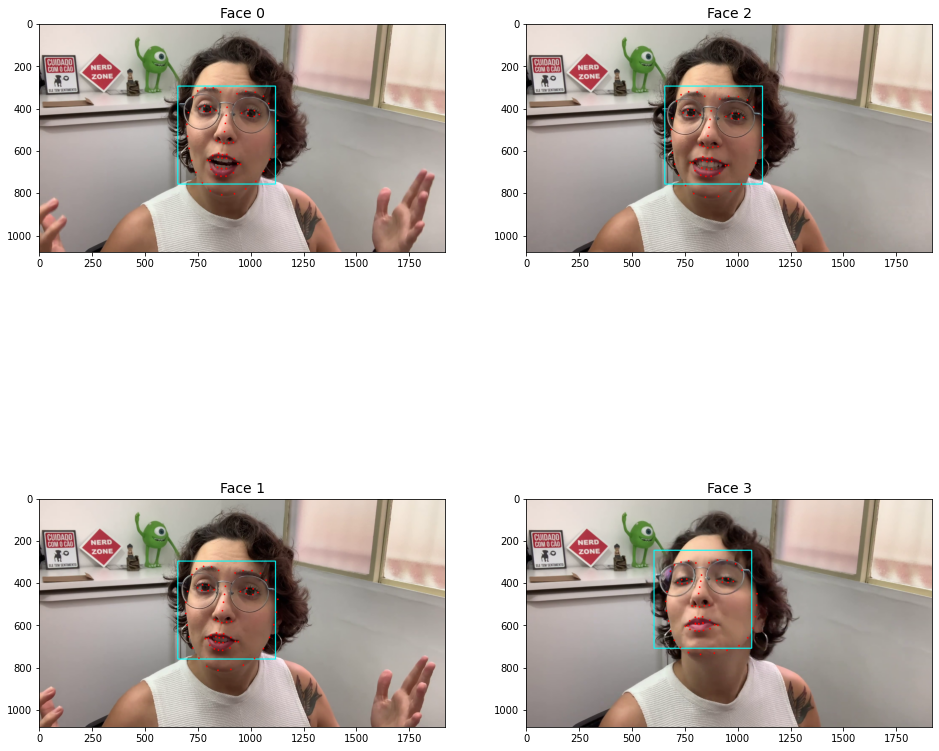

In [11]:
#mostra algumas faces detectadas de exemplo
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize=(16, 16))
i = 0
for y in range(0, 2):
    for x in range(0, 2):
        axes[x, y].set_title('Face ' + str(i), fontsize = 14)
        exampleFaces[i] = cv2.cvtColor(exampleFaces[i], cv2.COLOR_BGR2RGB)
        axes[x, y].imshow(exampleFaces[i])
        i += 1

# 3. Treino de Modelo de Faces da Camila e da Vivi

In [12]:
import face_recognition
import pickle

def generateEncodings(folderName, labelName, knownEncodings, knownNames):
    for filename in os.listdir(folderName):
        img = face_recognition.load_image_file(folderName + filename)
        boxes = face_recognition.face_locations(img, model = 'cnn')
        encodings = face_recognition.face_encodings(img, boxes)

        for encoding in encodings:
            knownEncodings.append(encoding)
            knownNames.append(labelName)

In [13]:
knownEncodings = []
knownNames = []

folderName = "Camila/"
labelName = "Camila"
generateEncodings(folderName, labelName, knownEncodings, knownNames)
       
folderName = "Vivi/"
labelName = "Vivi"
generateEncodings(folderName, labelName, knownEncodings, knownNames)

data_encoding = {"encodings": knownEncodings, "names": knownNames}

f = open("face_encodings", "wb")
f.write(pickle.dumps(data_encoding))
f.close()

# 4. Gerar Vídeo Reconhecendo Faces

In [14]:
import os.path

youtube_url = "https://www.youtube.com/watch?v=kflEcWii_Ug"
video_filename = "teste_mila_e_vivi.mp4"

if os.path.isfile(video_filename) == False:
    download_youtube_video(youtube_url, video_filename)

In [15]:
from tqdm import tqdm

#carrega arquivo binário contendo faces codificadas
data_encoding = pickle.loads(open("face_encodings", "rb").read())

#carrega vídeo do disco
videoCaptureInput = cv2.VideoCapture(video_filename)

#set contendo as possíveis pessoas reconhecidas
unique_names = set(data_encoding["names"])

#gerador de vídeo contendo saída com faces reconhecidas
fourcc = cv2.VideoWriter_fourcc('X', 'V', 'I', 'D')
fps = videoCaptureInput.get(cv2.CAP_PROP_FPS)
videoCaptureOutput = cv2.VideoWriter("output.mp4", fourcc, fps, (1920, 1080))

#gera reconhecimento em vídeo para os 200 primeiros frames
for i in tqdm(range(0, 200)):
    
    #para cada frame
    success, frame = videoCaptureInput.read()
        
    #acabou o vídeo?
    if success == False:
        break
        
    #converte frame de formato BGR (OpenCV) para RGB (face_recognition)
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    boxes = face_recognition.face_locations(frame, model = 'cnn')
    encodings = face_recognition.face_encodings(frame, boxes)
    
    names = []

    #para cada codificação de faces encontrada
    for encoding in encodings:
        matches = face_recognition.compare_faces(data_encoding["encodings"], encoding)
        
        #retorna o identificador da lista das faces da base que "batem" com a codificação verificada
        matchesId = [i for i, value in enumerate(matches) if value == True]
        
        #faz uma espécie de "votação": quem tiver mais codificações "próximas" das faces treinadas na base "ganha"
        counts = {}
        for name in unique_names:
            counts[name] = 0  
        for i in matchesId:
            name = data_encoding["names"][i]
            counts[name] += 1
        name = max(counts, key = counts.get)
        names.append(name)

    #desenha o retângulo e escreve o nome da pessoa no frame
    for ((top, right, bottom, left), name) in zip(boxes, names):
        cv2.rectangle(frame, (left, top), (right, bottom), (0, 255, 0), 4)
        cv2.putText(frame, name, (left, top), cv2.FONT_HERSHEY_SIMPLEX, 4, (0, 255, 0), 4)
    
    #converte o frame de volta pro formato do OpenCV (BGR)
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
    
    #escreve o frame no arquivo de vídeo
    videoCaptureOutput.write(frame)

videoCaptureInput.release()
videoCaptureOutput.release()

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [01:04<00:00,  3.09it/s]


In [17]:
import subprocess

subprocess.call(['ffmpeg', '-y', '-i', 'output.mp4', '-vf', 'fps=10,scale=640:-1:flags=lanczos,split[s0][s1];[s0]palettegen[p];[s1][p]paletteuse', '-loop', '1', 'output.gif'])

0

<img src="output.gif" align="center">